## Read in data

In [1]:
from google.colab import drive
from scipy import spatial
import seaborn as sns
import pandas as pd
import os
import json

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
data = "/content/gdrive/MyDrive/Capstone/Data/pipeline_reports"
all_files = os.listdir(data)
all_json = {}
for file in all_files:
    if "vfinal" in file:
        with open(data + "/" + file,) as inputfile:
            all_json[file] = json.load(inputfile)

In [ ]:
#test
all_json['all_asian_banks_preprocessed.json'][0]["filtered_report_pages_direct"]

## Preprocess Data for BERT Embeddings
1. remove numbers --> SCRAPE BECAUSE THE WHOLE POINT IS TO BE ABLE TO CAPTURE NUMBERS???????
2. remove punctuations except %,$,&
- as numbers & punctations are encoded differently
- upper/lower casing dont affect embeddings

Json Fields Used : 
1. use *filtered_report_sentences_direct* & *filtered_report_sentences_indirect* keys to get page numbers of relevant pages and get the unprocesse sentences from *report_sentences*

In [3]:
def remove_numbers(string):
    return ''.join(i for i in string if not i.isdigit())

def remove_punc(s):
    import string
    exclude = string.punctuation
    final_punc = ''.join(list(i for i in exclude if i not in ['%', '$', '&']))
    s = ''.join(ch for ch in s if ch not in list(final_punc))
    return s


In [ ]:
bert_json = {}
for json_name,json in all_json.items():
    fi_list = []
    for fi in json:
        fi_dict = {}
        fi_direct_dict = {}
        for page in fi["filtered_report_pages_direct"].keys():
            page = int(page)
#           fi_direct_dict[page] = list(map(lambda x : remove_punc(x) ,list(map(lambda x : remove_numbers(x) ,fi["report_sentences"][page-1]))))
            fi_direct_dict[page] = list(map(lambda x : remove_punc(x) ,fi["report_sentences"][page-1]))
        fi_indirect_dict = {}
        for page in fi["filtered_report_pages_indirect"].keys():
            page = int(page)
 #          fi_indirect_dict[page] = list(map(lambda x : remove_punc(x) ,list(map(lambda x : remove_numbers(x) ,fi["report_sentences"][page-1]))))
            fi_indirect_dict[page] =  list(map(lambda x : remove_punc(x) ,fi["report_sentences"][page-1]))      
        fi_dict["company"] = fi["company"] #identifier
        fi_dict["year"] = fi["year"] #identifier
        fi_dict["filtered_report_pages_direct_bert"]  = fi_direct_dict
        fi_dict["filtered_report_pages_indirect_bert"]  = fi_indirect_dict
        fi_list.append(fi_dict)
    bert_json[json_name] = fi_list
    
    


### BERT embeddings

Compare text similarity:
- BERT embeddings + Cosine Similarity does the best


Reference : https://medium.com/@adriensieg/text-similarities-da019229c894


In [4]:
%tensorflow_version 1.x

!pip install bert-serving-client
!pip install -U bert-serving-server[http]

!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
!unzip uncased_L-12_H-768_A-12.zip
!nohup bert-serving-start -model_dir=./uncased_L-12_H-768_A-12 > out.file 2>&1 &


!ls  # you should see uncased_something_.zip



TensorFlow 1.x selected.
     |████████████████████████████████| 61 kB 216 kB/s 
     |████████████████████████████████| 357 kB 11.3 MB/s 
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=7f5e7c8b704528512868ec15b1ab5ad79d266aa0b4fdd46f1b603e28ab92ba7c
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built GPUtil
--2021-11-01 19:03:50--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.193.128, 173.194.194.128, 173.194.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M   169MB/s    in 2.3s    

2021-11-01 19:03:52 (169 MB/s) - ‘uncased_L-12

In [5]:
from bert_serving.client import BertClient
bc = BertClient(check_length=False)

relevant_sentences = ['In 2019, Citi financed $74 million of subordinate lien bonds that were certified green, given the projects environmental aspects.', 
             'In addition, our cogeneration plant, fueled by natural gas, will produce heat and electricity on-site, reducing the building\'s carbon footprint by 34 percent.',
             'These efforts reduced energy consumption by more than 2,100 metric tons (mt) of carbon dioxide equivalents (CO2e) during the one-year challenge.',
             'The companies in our equity portfolio emitted around 133 tonnes of CO2 -equivalents for every million US dollars of revenue.', 
             'The equity portfolio’s carbon intensity was 9 percent below that of the benchmark index.',
             'A total of 106 companies that produce certain types of weapon, tobacco or coal, or use coal for power production, are currently excluded from the fund', 
             'For public and private assets, excluding cash and non-equity derivatives as they were not reported in 2019, our year-overyear portfolio weighted average carbon intensity was reduced by approximately 23%.',
             'Having met these targets, we have set new, more ambitious ones: to reduce the Fund’s emissions intensity by 40% and fossil fuel reserves by 80% by 2025.',
             'The carbon footprint of the non-listed companies was 0.6 tCO₂e per million SEK invested',
             'Energy consumption and carbon emissions per unit area were 149 kWh/ m² and 0.037 tCO₂e/m², which means a reduction of 9 per cent and 12 per cent, respectively.',
             'The carbon intensity (CO2 equivalent tons per million yen of sales) of GPIF’s equity and corporate bond portfolio decreased by 15.3%, from 2.29 tons to 1.94 tons, in the space of a year.'
             'Based on our percentage holdings in each company, the total emissions of the equity portfolio were 108 million tonnes of CO2 - equivalents in 2019.',
             'The carbon footprint of the companies in our equity portfolio',
             'The companies in our equity portfolio emitted around 156 tonnes of CO2 -equivalents for every million US dollars (USD) of revenue.'
             'The carbon intensity of the companies in the equity portfolio and the benchmark index decreased by 16 and 17 percent respectively from 2018 to 2019.',
             'We are focused on supporting the goal of net zero greenhouse gas emissions by 2050, in line with global efforts to limit warming to 1.5°C. ',
             'quantitative target for ESG-themed investments and finance of ¥700 billion ',
             'Commit to reduce investment carbon footprint by',
             'esg investing', 'green bonds', 'Green Investment target', 'Achieve 100% renewable electricity by 2025'
             ]
relevant_sentences_embeddings = bc.encode(relevant_sentences)

print(relevant_sentences_embeddings)

[[-0.10375775 -0.41058773  0.6212927  ... -0.29355988  0.26888955
   0.14812963]
 [ 0.76116025 -0.06709035  0.07512389 ... -0.04068742  0.14368583
   0.19906425]
 [-0.06862521  0.08689015  0.13055946 ... -0.22566105  0.22352234
  -0.00201502]
 ...
 [-0.15848124 -0.2721892  -0.12754104 ... -0.069576   -0.19471477
   0.15317261]
 [-0.02237912 -0.6119282  -0.27465814 ... -0.12987773 -0.4983658
  -0.05472057]
 [ 0.10988103 -0.53783214  0.6870812  ... -0.6287739   0.19253941
  -0.21154976]]


In [ ]:
def cosine_distance(s1,s2):
    return 1 - spatial.distance.cosine(s1, s2)

In [ ]:
all_cosine_similarities_ = [] # all combinations of cosine similarity
all_filtered_sentences = []

In [ ]:
all_relevant_sentences = []
for json_name,json in bert_json.items():
    fi_list = []
    for fi_index in range(len(json))[:10]: #change
        fi = json[fi_index]
        page_relevant_sentences = {}
        page_relevant_sentences_original = {}
        for page_number, page in fi["filtered_report_pages_direct_bert"].items():
            relevant_sentences = []
            relevant_sentences_original = []
            for sentence_index in range(len(page)):
                original_sentence = all_json[json_name][fi_index]["report_sentences"][page_number-1][sentence_index]
                all_filtered_sentences.append(original_sentence)
                sentence = page[sentence_index]
                sentence_encoding = bc.encode([sentence])[0]
                for relevant_sentence in relevant_sentences_embeddings:
                    cosine_similarity = cosine_distance(sentence_encoding,relevant_sentence)
                    all_cosine_similarities.append(cosine_similarity)
                    if cosine_similarity >= 0.8 : # tentative
                        relevant_sentences.append([sentence,cosine_similarity])
                        relevant_sentences_original.append(original_sentence)
                        all_relevant_sentences.append(original_sentence)
                        break
            if len(relevant_sentences) != 0 :
                page_relevant_sentences[page_number] = relevant_sentences
                page_relevant_sentences_original[page_number] = relevant_sentences_original
        bert_json[json_name][fi_index]["bert_relevant_sentences_direct"] = page_relevant_sentences
        bert_json[json_name][fi_index]["bert_relevant_sentences_direct_original"] = page_relevant_sentences_original


        page_relevant_sentences_indirect = {}
        page_relevant_sentences_indirect_original = {}
        for page_number, page in fi["filtered_report_pages_indirect_bert"].items():
            relevant_sentences = []
            relevant_sentences_original = []
            for sentence_index in range(len(page)):
                original_sentence = all_json[json_name][fi_index]["report_sentences"][page_number-1][sentence_index]
                all_filtered_sentences.append(original_sentence)
                sentence = page[sentence_index]
                sentence_encoding = bc.encode([sentence])[0]
                for relevant_sentence in relevant_sentences_embeddings:
                    cosine_similarity = cosine_distance(sentence_encoding,relevant_sentence)
                    all_cosine_similarities.append(cosine_similarity)
                    if cosine_similarity >= 0.7357 : # tentative maybe must b smilar to most terms?
                        relevant_sentences.append([sentence,cosine_similarity])
                        relevant_sentences_original.append(original_sentence)
                        all_relevant_sentences.append(original_sentence)
                        break
            if len(relevant_sentences) != 0 :
                page_relevant_sentences_indirect[page_number] = relevant_sentences
                page_relevant_sentences_indirect_original[page_number] = relevant_sentences_original
        bert_json[json_name][fi_index]["bert_relevant_sentences_indirect"] = page_relevant_sentences_indirect
        bert_json[json_name][fi_index]["bert_relevant_sentences_indirect_original"] = page_relevant_sentences_indirect_original

                

,cos_similarity
count,249264.000000
mean,0.681896
std,0.079136
min,0.206599
25%,0.641717
50%,0.693079
75%,0.735703
max,1.000000


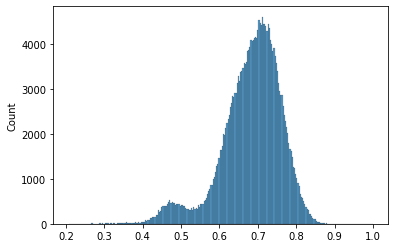

In [ ]:
# to determine threshold
sns.histplot(all_cosine_similarities)
pd.DataFrame(all_cosine_similarities,columns=["cos_similarity"]).describe()

In [ ]:
print(len(all_filtered_sentences))
print(len(all_relevant_sentences))

18465
8470


### Splitting Data for labelling

In [ ]:
# all_filtered_sentences_df = pd.DataFrame(all_filtered_sentences,columns=["filtered_sentences"])
# n = all_filtered_sentences_df.shape[0]//5
# split_1 = all_filtered_sentences_df.sample(n=n,random_state=200) #random state is a seed value
# test = all_filtered_sentences_df.drop(split_1.index)
# split_2 = test.sample(n=n,random_state=200)
# test = test.drop(split_2.index)
# split_3 = test.sample(n=n,random_state=200) 
# test = test.drop(split_3.index)
# split_4 = test.sample(n=n,random_state=200) 
# test = test.drop(split_4.index)
# split_5 = test
 
data = "/content/gdrive/MyDrive/Capstone/Data/to_label"
all_relevant_sentences_df = pd.DataFrame(all_relevant_sentences,columns=["relevant_sentences"])
n = all_relevant_sentences_df.shape[0]//5
split_1 = all_relevant_sentences_df.sample(n=n,random_state=200)
split_1.to_csv(data + "/split_1.csv")
test = all_relevant_sentences_df.drop(split_1.index)
print(test.shape)
split_2 = test.sample(n=n,random_state=200)
split_2.to_csv(data + "/split_2.csv")
test = test.drop(split_2.index)
print(test.shape)
split_3 = test.sample(n=n,random_state=200)
split_3.to_csv(data + "/split_3.csv")
test = test.drop(split_3.index)
split_4 = test.sample(n=n,random_state=200)
split_4.to_csv(data + "/split_4.csv")
test = test.drop(split_4.index)
split_5 = test
split_5.to_csv(data + "/split_5.csv")


(6776, 1)
(5082, 1)


# Pipeline

In [ ]:
from google.colab import drive
from scipy import spatial
import seaborn as sns
import pandas as pd
import os
import json
import numpy


# drive.mount('/content/gdrive')

In [2]:
# helper functions
def remove_punc(s):
    import string
    exclude = string.punctuation
    final_punc = ''.join(list(i for i in exclude if i not in ['%', '$', '&']))
    s = ''.join(ch for ch in s if ch not in list(final_punc))
    return s

def cosine_distance(s1,s2):
    return 1 - spatial.distance.cosine(s1, s2)

In [ ]:
# bert as a service
%tensorflow_version 1.x

!pip install bert-serving-client
!pip install -U bert-serving-server[http]

!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
!unzip uncased_L-12_H-768_A-12.zip
!nohup bert-serving-start -model_dir=./uncased_L-12_H-768_A-12 > out.file 2>&1 &


!ls  # you should see uncased_something_.zip


In [ ]:
# from bert_serving.client import BertClient
# import numpy
# bc = BertClient(check_length=False)

def create_bert_embeddings(jsonfile):
  if jsonfile["bert_relevant_sentences_direct_original"] != {}:
    embeddings_dict = {}
    for page,sentences in jsonfile["bert_relevant_sentences_direct_original"].items():
      embeddings_dict[page] = []
      for sentence in sentences:
        sentence_encoding = list(bc.encode([sentence])[0])       
        embeddings_dict[page].append(list(map(lambda x: numpy.float64(x),sentence_encoding)))
    jsonfile["bert_relevant_sentences_direct_original_embeddings"] = embeddings_dict
  else:
    jsonfile["bert_relevant_sentences_direct_original_embeddings"] = {}

  if jsonfile["bert_relevant_sentences_indirect_original"] != {}:
    embeddings_dict = {}
    for page,sentences in jsonfile["bert_relevant_sentences_indirect_original"].items():
      embeddings_dict[page] = []
      for sentence in sentences:
        sentence_encoding = list(bc.encode([sentence])[0])       
        embeddings_dict[page].append(list(map(lambda x: numpy.float64(x),sentence_encoding)))
    jsonfile["bert_relevant_sentences_indirect_original_embeddings"] = embeddings_dict
  else:
    jsonfile["bert_relevant_sentences_indirect_original_embeddings"] = {}
  return jsonfile

In [31]:
# to process 1 json
def bert_filtering(file_path):
    with open(file_path,) as inputfile:
        json_file = json.load(inputfile)
        json_file = [json_file]
    fi_list = []
    #step 1
    for fi in json_file:
        fi_dict = {}
        fi_direct_dict = {}
        for page in fi["filtered_report_pages_direct"].keys():
            page = int(page)
            fi_direct_dict[page] = list(map(lambda x : remove_punc(x) ,fi["report_sentences"][page-1]))
        fi_indirect_dict = {}
        for page in fi["filtered_report_pages_indirect"].keys():
            page = int(page)
            fi_indirect_dict[page] =  list(map(lambda x : remove_punc(x) ,fi["report_sentences"][page-1]))      
        fi_dict["company"] = fi["company"] #identifier
        fi_dict["year"] = fi["year"] #identifier
        fi_dict["url"] = fi["url"]
        fi_dict["filtered_report_pages_direct_bert"]  = fi_direct_dict
        fi_dict["filtered_report_pages_indirect_bert"]  = fi_indirect_dict
        fi_list.append(fi_dict)
        
    # insttantiate BERT
    from bert_serving.client import BertClient
    bc = BertClient(check_length=False)

    relevant_sentences = ['In 2019, Citi financed $74 million of subordinate lien bonds that were certified green, given the projects environmental aspects.', 
                'In addition, our cogeneration plant, fueled by natural gas, will produce heat and electricity on-site, reducing the building\'s carbon footprint by 34 percent.',
                'These efforts reduced energy consumption by more than 2,100 metric tons (mt) of carbon dioxide equivalents (CO2e) during the one-year challenge.',
                'The companies in our equity portfolio emitted around 133 tonnes of CO2 -equivalents for every million US dollars of revenue.', 
                'The equity portfolio’s carbon intensity was 9 percent below that of the benchmark index.',
                'A total of 106 companies that produce certain types of weapon, tobacco or coal, or use coal for power production, are currently excluded from the fund', 
                'For public and private assets, excluding cash and non-equity derivatives as they were not reported in 2019, our year-overyear portfolio weighted average carbon intensity was reduced by approximately 23%.',
                'Having met these targets, we have set new, more ambitious ones: to reduce the Fund’s emissions intensity by 40% and fossil fuel reserves by 80% by 2025.',
                'The carbon footprint of the non-listed companies was 0.6 tCO₂e per million SEK invested',
                'Energy consumption and carbon emissions per unit area were 149 kWh/ m² and 0.037 tCO₂e/m², which means a reduction of 9 per cent and 12 per cent, respectively.',
                'The carbon intensity (CO2 equivalent tons per million yen of sales) of GPIF’s equity and corporate bond portfolio decreased by 15.3%, from 2.29 tons to 1.94 tons, in the space of a year.'
                'Based on our percentage holdings in each company, the total emissions of the equity portfolio were 108 million tonnes of CO2 - equivalents in 2019.',
                'The carbon footprint of the companies in our equity portfolio',
                'The companies in our equity portfolio emitted around 156 tonnes of CO2 -equivalents for every million US dollars (USD) of revenue.'
                'The carbon intensity of the companies in the equity portfolio and the benchmark index decreased by 16 and 17 percent respectively from 2018 to 2019.',
                'We are focused on supporting the goal of net zero greenhouse gas emissions by 2050, in line with global efforts to limit warming to 1.5°C. ',
                'quantitative target for ESG-themed investments and finance of ¥700 billion ',
                'Commit to reduce investment carbon footprint by',
                'esg investing', 'green bonds', 'Green Investment target', 'Achieve 100% renewable electricity by 2025']
    relevant_sentences_embeddings = bc.encode(relevant_sentences)

    #step 2
    json_list = fi_list
    for fi_index in range(len(json_list)): #remove
        fi = json_list[fi_index]
        page_relevant_sentences = {}
        page_relevant_sentences_original = {}
        for page_number, page in fi["filtered_report_pages_direct_bert"].items():
            relevant_sentences = []
            relevant_sentences_original = []
            for sentence_index in range(len(page)):
                original_sentence = json_file[fi_index]["report_sentences"][page_number-1][sentence_index]
                sentence = page[sentence_index]
                sentence_encoding = bc.encode([sentence])[0]
                for relevant_sentence in relevant_sentences_embeddings:
                    cosine_similarity = cosine_distance(sentence_encoding,relevant_sentence)
                    if cosine_similarity >= 0.8 : # tentative
                        relevant_sentences.append(sentence)
                        relevant_sentences_original.append(original_sentence)
                        break
            if len(relevant_sentences) != 0 :
                page_relevant_sentences[page_number] = relevant_sentences
                page_relevant_sentences_original[page_number] = relevant_sentences_original
        #json_list[fi_index]["bert_relevant_sentences_direct"] = page_relevant_sentences
                #print(len(relevant_sentences))
        json_list[fi_index]["bert_relevant_sentences_direct_original"] = page_relevant_sentences_original # sentences used to train


        page_relevant_sentences_indirect = {}
        page_relevant_sentences_indirect_original = {}
        for page_number, page in fi["filtered_report_pages_indirect_bert"].items():
            relevant_sentences = []
            relevant_sentences_original = []
            for sentence_index in range(len(page)):
                original_sentence = json_file[fi_index]["report_sentences"][page_number-1][sentence_index]
                sentence = page[sentence_index]
                sentence_encoding = bc.encode([sentence])[0]
                for relevant_sentence in relevant_sentences_embeddings:
                    cosine_similarity = cosine_distance(sentence_encoding,relevant_sentence)
                    if cosine_similarity >= 0.7357 : # tentative maybe must b smilar to most terms?
                        relevant_sentences.append(sentence)
                        relevant_sentences_original.append(original_sentence)
                        break
            if len(relevant_sentences) != 0 :
                page_relevant_sentences_indirect[page_number] = relevant_sentences
                page_relevant_sentences_indirect_original[page_number] = relevant_sentences_original
                #print(len(relevant_sentences))
        #json_list[fi_index]["bert_relevant_sentences_indirect"] = page_relevant_sentences_indirect
        json_list[fi_index]["bert_relevant_sentences_indirect_original"] = page_relevant_sentences_indirect_original # sentences used to train
        

    #step 3 create embeddings
    final_json_embeddings = create_bert_embeddings(json_list[0])
    output_path = file_path[:-5] + "_BERT_embeddings.json"
    

    with open(output_path, "w") as outfile:  
        json.dump(final_json_embeddings, outfile)

    return output_path




In [33]:
DATA_FOLDER = "/content/gdrive/MyDrive/Capstone/Data/pipeline_reports/"
all_files = os.listdir(DATA_FOLDER)
for file in all_files:
    file_path = DATA_FOLDER + file
    # output_name = DATA_FOLDER + file[:-5] + "_BERT_embeddings.json"
    output_path = bert_filtering(file_path)


Create embeddings json

In [27]:
# from bert_serving.client import BertClient
# import numpy
# bc = BertClient(check_length=False)

def create_bert_embeddings(jsonfile):
  if jsonfile["bert_relevant_sentences_direct_original"] != {}:
    embeddings_dict = {}
    for page,sentences in jsonfile["bert_relevant_sentences_direct_original"].items():
      embeddings_dict[page] = []
      for sentence in sentences:
        sentence_encoding = list(bc.encode([sentence])[0])       
        embeddings_dict[page].append(list(map(lambda x: numpy.float64(x),sentence_encoding)))
    jsonfile["bert_relevant_sentences_direct_original_embeddings"] = embeddings_dict
  else:
    jsonfile["bert_relevant_sentences_direct_original_embeddings"] = {}

  if jsonfile["bert_relevant_sentences_indirect_original"] != {}:
    embeddings_dict = {}
    for page,sentences in jsonfile["bert_relevant_sentences_indirect_original"].items():
      embeddings_dict[page] = []
      for sentence in sentences:
        sentence_encoding = list(bc.encode([sentence])[0])       
        embeddings_dict[page].append(list(map(lambda x: numpy.float64(x),sentence_encoding)))
    jsonfile["bert_relevant_sentences_indirect_original_embeddings"] = embeddings_dict
  else:
    jsonfile["bert_relevant_sentences_indirect_original_embeddings"] = {}
  return jsonfile

In [30]:
import numpy

file_path = "/content/gdrive/MyDrive/Capstone/Data/pipeline_reports/Canada Pension2017_BERT.json"
with open(file_path,) as inputfile:
    json_file = json.load(inputfile)

json_file_embeddings = []
for fi in json_file:
  json_file_embeddings.append(create_bert_embeddings(fi))

output_name = file_path = DATA_FOLDER + "all_vfinal_BERT_embeddings.json"
with open(output_name, "w") as outfile:  
    json.dump(json_file_embeddings, outfile)


In [12]:
processed_json[0].keys()

dict_keys(['company', 'year', 'filtered_report_pages_direct_bert', 'filtered_report_pages_indirect_bert', 'bert_relevant_sentences_direct_original', 'bert_relevant_sentences_indirect_original'])